In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, optimizers, regularizers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import numpy as np
# Load custom stylesheet for plots
plt.style.use('https://raw.githubusercontent.com/benediktstroebl/hosted-files/main/custom_style.mplstyle')

In [2]:
# Load CIFAR-10 data and start with combining the train and test splits
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
images = np.concatenate((train_images,test_images),axis = 0)
labels = np.concatenate((train_labels, test_labels), axis = 0)

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Shuffle our images and labels
images, labels = shuffle(images, labels)

In [3]:
# Define training/test set size for entire attack scenario
set_size = 3000

# Take train and test set for target model
train_images_target = images[:set_size]
train_labels_target = labels[:set_size]

test_images_target = images[set_size:2*set_size]
test_labels_target = labels[set_size:2*set_size]

# Use remaining (disjoint) samples as pool to draw random samples for each shadow model later (the shadow model train/test sets might overlap)
images_shadow_pool = images[2*set_size:]
labels_shadow_pool = labels[2*set_size:]

In [4]:
# Define basic CNN model structure
target_model = models.Sequential()
target_model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)))
target_model.add(layers.MaxPooling2D((2, 2)))
target_model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
target_model.add(layers.MaxPooling2D((2, 2)))
target_model.add(layers.Flatten())
target_model.add(layers.Dense(128, activation='tanh'))
target_model.add(layers.Dense(10, activation='softmax'))

# Print target model structure
target_model.summary()

In [5]:
def train_target_model(target_model, train_images_target, train_labels_target, test_images_target, test_labels_target, n_epochs=30):
  target_model.compile(
      optimizer='adam', 
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )

  history = target_model.fit(
      train_images_target, 
      train_labels_target, 
      epochs=n_epochs, 
      validation_data=(test_images_target, test_labels_target)
  )

  return target_model, history

(target_model, history) = train_target_model(target_model, train_images_target, train_labels_target, test_images_target, test_labels_target)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


94/94 [==============================] - 8s 10ms/step - loss: 1.9804 - accuracy: 0.2960 - val_loss: 1.7812 - val_accuracy: 0.3570
Epoch 2/30
94/94 [==============================] - 1s 7ms/step - loss: 1.6346 - accuracy: 0.4197 - val_loss: 1.6618 - val_accuracy: 0.3957
Epoch 3/30
94/94 [==============================] - 1s 6ms/step - loss: 1.4598 - accuracy: 0.4897 - val_loss: 1.5432 - val_accuracy: 0.4627
Epoch 4/30
94/94 [==============================] - 1s 7ms/step - loss: 1.3234 - accuracy: 0.5367 - val_loss: 1.5547 - val_accuracy: 0.4537
Epoch 5/30
94/94 [==============================] - 1s 7ms/step - loss: 1.1709 - accuracy: 0.5963 - val_loss: 1.4938 - val_accuracy: 0.4843
Epoch 6/30
94/94 [==============================] - 1s 6ms/step - loss: 1.0406 - accuracy: 0.6423 - val_loss: 1.5285 - val_accuracy: 0.4790
Epoch 7/30
94/94 [==============================] - 1s 7ms/step - loss: 0.8813 - accuracy: 0.7050 - val_loss: 1.5398 - val_accuracy: 0.4927
Epoch 8/30
94/94 [============

313/313 - 1s - loss: 4.8005 - accuracy: 0.3544 - 830ms/epoch - 3ms/step


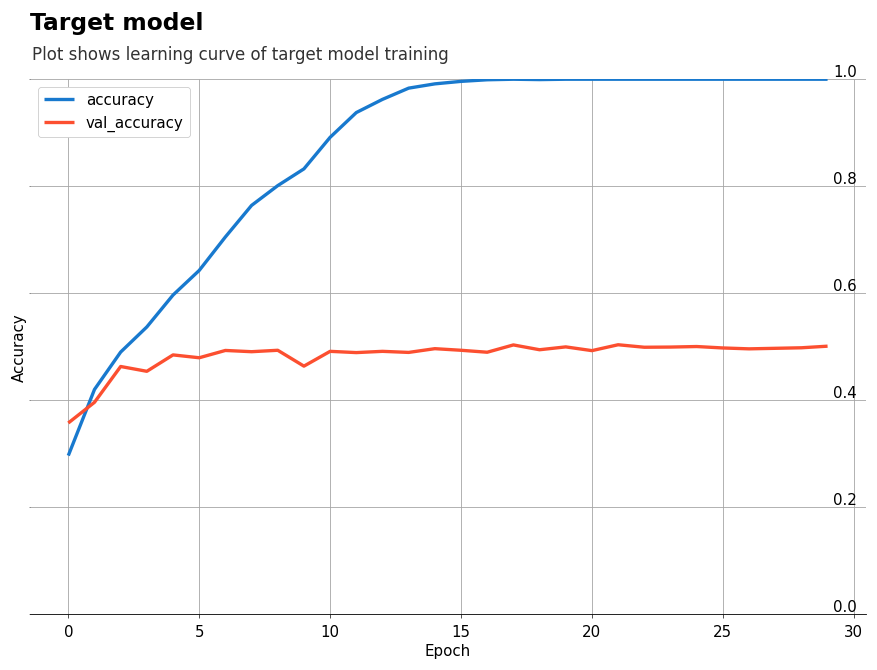

In [6]:
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax.set_title('Target model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
ax.legend(loc='upper left')
ax.text(x=.082, y=.91, 
        s="Plot shows learning curve of target model training", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

test_loss, test_acc = target_model.evaluate(test_images,  test_labels, verbose=2)

In [7]:
# Create shadow models that all have the exact same structure as the target model (but newly initialized weights)
# Here we are assuming that the adversary is using the same API as the target model user. Thus, the adversary does not know the exact architecture but uses the same service.
num_shadow_models = 40

shadow_models = [models.clone_model(target_model) for i in range(num_shadow_models)]

In [8]:
def create_shadow_models_datasets(images_shadow_pool, labels_shadow_pool, num_shadow_models, set_size = set_size):
  """
  This function generates the individual training and test sets for each of our shadow model. 
  It uses the data pool for all shadow model that is disjoint from the target model's data (as defined earlier).
  We draw random samples from this data pool for training and test set of the same size.
  While there might be overlaps in data between the shadow models, we ensure that each shadown model has disjoint training and test sets.
  """
  train_images_shadow = []
  train_labels_shadow = []
  test_images_shadow = []
  test_labels_shadow = []

  for i in range(num_shadow_models):
    # generate random numbers from uniform sample (without duplicates) to select train and test samples
    random_sample = random.sample(population=range(len(images_shadow_pool)), k=2*set_size)
    train_idx = random_sample[:set_size] # take train idx from random numbers
    test_idx = random_sample[set_size:] # take disjoint test idx from random numbers

    # Select train images with random idx just generated from shadow data pool 
    train_images_shadow.append(images_shadow_pool[train_idx])
    # Do the same for train labels but also add new column with In/Out label (train --> 1:In)
    train_labels_shadow.append(np.hstack((labels_shadow_pool[train_idx], np.ones(shape=(set_size,1), dtype='uint8'))))

    # Select test images with random idx just generated from shadow data pool 
    test_images_shadow.append(images_shadow_pool[test_idx])
    # Do the same for test labels but also add new column with In/Out label (test --> 0:Out)
    test_labels_shadow.append(np.hstack((labels_shadow_pool[test_idx], np.zeros(shape=(set_size,1), dtype='uint8'))))

  return (train_images_shadow, train_labels_shadow), (test_images_shadow, test_labels_shadow)


def compile_models(models):
  """
  This function is used to compile all models in a list of models.
  We use this for compiling our shadow and attack models.
  """
  opt = optimizers.SGD(learning_rate=0.01)
  
  for m in models:
    m.compile(
        optimizer=opt, 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
  return models


def fit_shadow_models(shadow_models, train_images_shadow, train_labels_shadow, test_images_shadow, test_labels_shadow, n_epochs=15):
  """
  This function is used to iterate over all our shadow models and fit them.
  Each of the shadow models is fitted on its respective train/test sets and then returned in its fitted state.
  """
  for idx, m in enumerate(shadow_models):
    print(f'Next Model: {idx+1}/{len(shadow_models)}')
    m.fit(
      train_images_shadow[idx], 
      train_labels_shadow[idx][:,[0]], # train shadow models on class labels not in/out lables 
      epochs=n_epochs, 
      validation_data=(test_images_shadow[idx], test_labels_shadow[idx][:,[0]])
    )

  return shadow_models

def fit_attack_models(attack_models, attack_x, attack_y, n_epochs=15):
  """
  This function is similar to fit_shadow_models and iterates over the individual attack models
  and fits them. There is a separate binary classifier attack model for each class in our data. 
  """
  for idx, m in enumerate(attack_models):
    print(f'Next Model: {idx+1}/{len(attack_models)}')
    m.fit(
      attack_x[idx], 
      attack_y[idx], 
      epochs=n_epochs, 
    )

  return attack_models

  

In [9]:
# Call above function to create the datasets for all our shadow models
(train_images_shadow, train_labels_shadow), (test_images_shadow, test_labels_shadow) = create_shadow_models_datasets(
    images_shadow_pool, 
    labels_shadow_pool, 
    num_shadow_models
)

In [10]:
# Compile shadow models
shadow_models = compile_models(shadow_models)

# Iterate over shadow models and fit each of them on its respective data sets
# NOTE: This cell takes approximately ~ 9 min. to run. Watch our video or read the accompanying memo :-)
shadow_models = fit_shadow_models(
    shadow_models,
    train_images_shadow,
    train_labels_shadow,
    test_images_shadow, 
    test_labels_shadow
)

Next Model: 0/40
Epoch 1/15
94/94 [==============================] - 1s 9ms/step - loss: 2.2487 - accuracy: 0.1713 - val_loss: 2.1821 - val_accuracy: 0.2073
Epoch 2/15
94/94 [==============================] - 1s 7ms/step - loss: 2.1169 - accuracy: 0.2503 - val_loss: 2.0586 - val_accuracy: 0.2720
Epoch 3/15
94/94 [==============================] - 1s 7ms/step - loss: 2.0064 - accuracy: 0.2973 - val_loss: 1.9784 - val_accuracy: 0.3013
Epoch 4/15
94/94 [==============================] - 1s 7ms/step - loss: 1.9344 - accuracy: 0.3217 - val_loss: 1.9598 - val_accuracy: 0.3093
Epoch 5/15
94/94 [==============================] - 1s 6ms/step - loss: 1.8753 - accuracy: 0.3467 - val_loss: 1.8728 - val_accuracy: 0.3557
Epoch 6/15
94/94 [==============================] - 1s 7ms/step - loss: 1.8253 - accuracy: 0.3660 - val_loss: 1.8431 - val_accuracy: 0.3507
Epoch 7/15
94/94 [==============================] - 1s 7ms/step - loss: 1.7804 - accuracy: 0.3887 - val_loss: 1.8398 - val_accuracy: 0.3463
Epo

In [11]:
def build_attack_model_data(shadow_models, train_images_shadow, train_labels_shadow, test_images_shadow, test_labels_shadow):
  """
  This function is used to create the data sets that are required for fitting the attack models.
  For each shadow model, we compute its predictions on its training and test data. 
  We combined the resulting confidence scores with the true label for each data point and the In/Out label for training/test set.
  We than split the data by the classes and in attack_X and attack_Y denominating the input and labels for the attack models training.
  """
  attack_x = []
  attack_y = []

  for idx, m in enumerate(shadow_models):
    # Get shadow model's data and combine train/test data
    images = np.vstack((train_images_shadow[idx], test_images_shadow[idx]))
    labels = np.vstack((train_labels_shadow[idx], test_labels_shadow[idx]))

    # Compute predictions for images
    conf_scores = m.predict(images)

    # Combine resulting confidence scores and true labels
    x = np.hstack((conf_scores, labels))

    # Append this shadow model's output to overall list
    attack_x.append(x)

  # Combine global list into one array
  attack_x = np.vstack(attack_x)

  # split attack_x and attack_y data along class values into list
  attack_x = {cls: attack_x[np.where(attack_x[:,[10]] == cls)[0]] for cls in range(10)}
  attack_y = [attack_x[d][:, [11]] for d in attack_x] # take In/Out column as attack_Y (labels)
  attack_x = [attack_x[d][:,:11] for d in attack_x] # Retain conf scores and true labels as attack_X (inputs)

  return (attack_x, attack_y)

In [12]:
# Build data for training attack models by predictin confidence scores for each shadow model and combining data
(attack_x, attack_y) = build_attack_model_data(shadow_models, train_images_shadow, train_labels_shadow, test_images_shadow, test_labels_shadow)

188/188 [==============================] - 1s 2ms/step


In [13]:
# Define structure of attack models
attack_model = models.Sequential()
attack_model.add(layers.Dense(64, activation='relu', input_shape=(11,)))
attack_model.add(layers.Dense(2, activation='softmax'))

# Print attack model structure
attack_model.summary()

In [15]:
# Create one attack model per class in our data
attack_models = [models.clone_model(attack_model) for i in range(len(attack_x))]

In [16]:
# Compile and fit our attack models on the data we created above by using the confidence scores from our shadow models
# NOTE: This cell takes approximately ~ 6,5 min. to run. Watch our video or read the accompanying memo :-)
attack_models = compile_models(attack_models)
attack_models = fit_attack_models(attack_models, attack_x, attack_y, 20)

Next Model: 0/10
Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


747/747 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5072
Epoch 2/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6923 - accuracy: 0.5163
Epoch 3/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6920 - accuracy: 0.5206
Epoch 4/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6918 - accuracy: 0.5209
Epoch 5/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6917 - accuracy: 0.5211
Epoch 6/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6916 - accuracy: 0.5220
Epoch 7/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6916 - accuracy: 0.5213
Epoch 8/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6915 - accuracy: 0.5224
Epoch 9/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6915 - accuracy: 0.5244
Epoch 10/20
747/747 [==============================] - 2s 2ms/step - loss: 0.6914 - accuracy: 0.5248
Epoch 11/2

In [18]:
def evaluate_attack_models(attack_models, target_model, train_images_target, train_labels_target, test_images_target, test_labels_target):
  """
  This function evaluates our attack model on the given target model.
  We calculate the predictions of the target model on its data.
  We combine this with the true labels and bring it in the form necessary for our attack model.
  Lastly, our attack models are evaluated on the data and we compute the performance of our attack per class.
  """

  # Query black box target model to obtain the confidence scores
  conf_scores_train = target_model.predict(train_images_target)
  conf_scores_test = target_model.predict(test_images_target)

  # Build the data structure needed for the attack model
  conf_scores = np.vstack((conf_scores_train, conf_scores_test))
  true_class_labels = np.vstack((train_labels_target, test_labels_target))
  in_out_labels = np.vstack((np.ones((len(conf_scores_train),1)), np.zeros((len(conf_scores_test), 1)))) # Create In/Out labels to evaluate model performance
  attack_eval = np.hstack([conf_scores, true_class_labels, in_out_labels])

  # split attack_eval data: (conf_scores, y_true, In/Out) into list with X: (conf_scores, y_true) and Y: (In/Out) for attack models for each class
  X_eval = {cls: attack_eval[np.where(attack_eval[:,[10]] == cls)[0]] for cls in range(10)}
  Y_eval = [X_eval[d][:, [11]] for d in X_eval]
  X_eval = [X_eval[d][:,:11] for d in X_eval]

  attack_eval = [attack_models[cls].evaluate(X_eval[cls], Y_eval[cls]) for cls in range(10)]
  attack_eval = np.vstack(attack_eval)

  return attack_eval

In [19]:
# Evaluate performance of attack models on target model and its data
# Reminder: this data is unseen to the attack models
attack_eval = evaluate_attack_models(attack_models, target_model, train_images_target, train_labels_target, test_images_target, test_labels_target)

20/20 [==============================] - 0s 3ms/step - loss: 0.6454 - accuracy: 0.7006


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.7099


Text(0.082, 0.91, 'Plot shows accuracy of attack on target model per class')

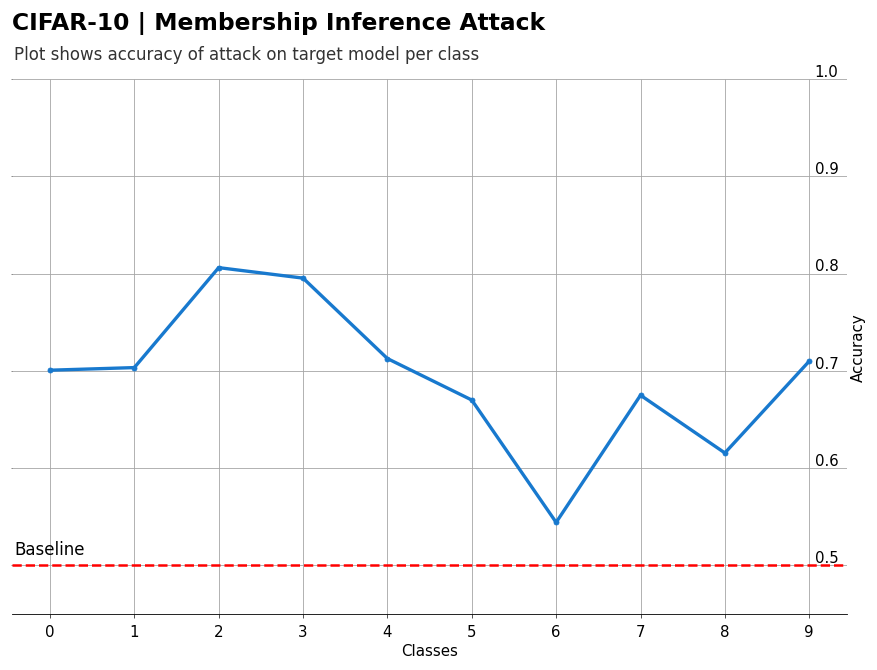

In [31]:
# Plot performance of our membership inference attack
fig, ax = plt.subplots()
ax.plot(attack_eval[:,1], marker='o')
ax.axhline(y=0.5, color='r', linestyle='--', linewidth=3)
ax.text(x=.082, y=.16, 
        s="Baseline", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20)
ax.set_title("CIFAR-10 | Membership Inference Attack")
ax.set_xlabel('Classes')
ax.set_ylabel('Accuracy')
ax.yaxis.set_label_position("right")
ax.set_ylim(bottom=0.45, top=1)
ax.set_xticks(np.arange(0, 10, step=1))
ax.text(x=.082, y=.91, 
        s="Plot shows accuracy of attack on target model per class", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

In [21]:
# Lets retrain our target model with applying L2 Regularization on our weights
target_model_l2_reg = models.Sequential()
target_model_l2_reg.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(0.01)))
target_model_l2_reg.add(layers.MaxPooling2D((2, 2)))
target_model_l2_reg.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
target_model_l2_reg.add(layers.MaxPooling2D((2, 2)))
target_model_l2_reg.add(layers.Flatten())
target_model_l2_reg.add(layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
target_model_l2_reg.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

train_target_model(target_model_l2_reg, train_images_target, train_labels_target, test_images_target, test_labels_target)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


94/94 [==============================] - 1s 9ms/step - loss: 3.7064 - accuracy: 0.2900 - val_loss: 2.6683 - val_accuracy: 0.3687
Epoch 2/30
94/94 [==============================] - 1s 6ms/step - loss: 2.3819 - accuracy: 0.3847 - val_loss: 2.2460 - val_accuracy: 0.3633
Epoch 3/30
94/94 [==============================] - 1s 7ms/step - loss: 2.1406 - accuracy: 0.4037 - val_loss: 2.1221 - val_accuracy: 0.3880
Epoch 4/30
94/94 [==============================] - 1s 7ms/step - loss: 2.0631 - accuracy: 0.4147 - val_loss: 2.0613 - val_accuracy: 0.4040
Epoch 5/30
94/94 [==============================] - 1s 7ms/step - loss: 1.9925 - accuracy: 0.4317 - val_loss: 2.0479 - val_accuracy: 0.4087
Epoch 6/30
94/94 [==============================] - 1s 7ms/step - loss: 1.9651 - accuracy: 0.4447 - val_loss: 2.0169 - val_accuracy: 0.4093
Epoch 7/30
94/94 [==============================] - 1s 6ms/step - loss: 1.9452 - accuracy: 0.4417 - val_loss: 1.9477 - val_accuracy: 0.4447
Epoch 8/30
94/94 [=============

(<keras.engine.sequential.Sequential at 0x7f24406bbaf0>,
 <keras.callbacks.History at 0x7f244067e2b0>)

In [22]:
# Evaluate our attack model on the L2-regularized target model 
attack_eval_l2_reg = evaluate_attack_models(attack_models, target_model_l2_reg, train_images_target, train_labels_target, test_images_target, test_labels_target)

19/19 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5868


Text(0.082, 0.91, 'Plot shows accuracy of attack on the target model per class with l2-regularization applied')

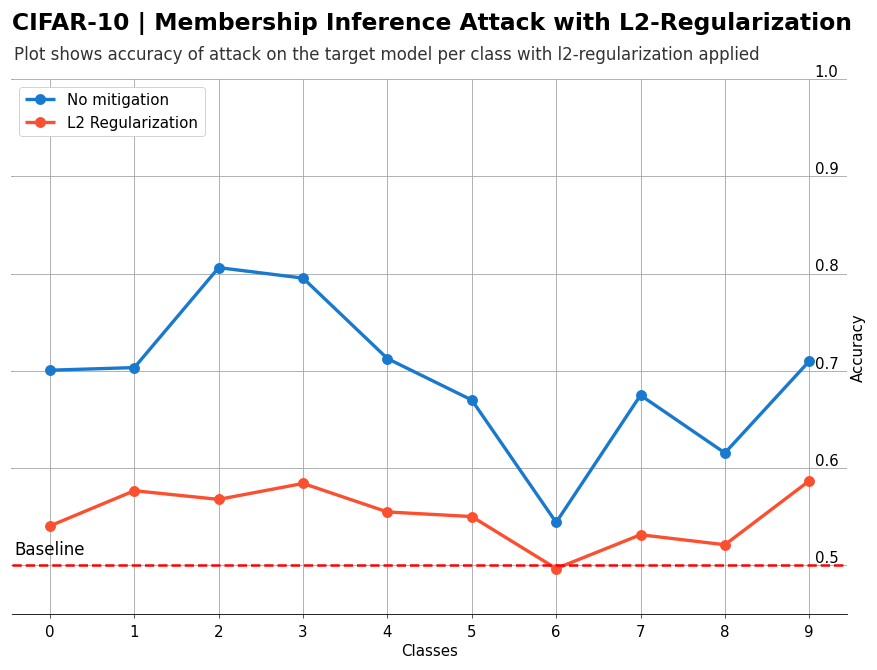

In [37]:
# Plot performance curve per class to compare mitigation performance
fig, ax = plt.subplots()
ax.plot(attack_eval[:,1], marker='o', markersize=12 , label="No mitigation")
ax.plot(attack_eval_l2_reg[:,1], marker='o', markersize=12, label="L2 Regularization")
ax.legend(loc='upper left')
ax.axhline(y=0.5, color='r', linestyle='--', linewidth=3)
ax.text(x=.082, y=.16, 
        s="Baseline", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20)
ax.set_title("CIFAR-10 | Membership Inference Attack with L2-Regularization")
ax.set_xlabel('Classes')
ax.set_ylabel('Accuracy')
ax.yaxis.set_label_position("right")
ax.set_ylim(bottom=0.45, top=1)
ax.set_xticks(np.arange(0, 10, step=1))
ax.text(x=.082, y=.91, 
        s="Plot shows accuracy of attack on the target model per class with L2-regularization applied", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)